# Libraries

In [1]:
import librosa
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import  KerasClassifier
from scipy.stats import randint, uniform
from sklearn.utils import resample
import seaborn as sns


# Load audio and labels

In [2]:
#Load the audio file
audio_path = "clips_lakers.wav"
audio, sr = librosa.load(audio_path, sr=None)

In [3]:
#Load labels from CSV file
labels_path = "annotation.csv"
labels_df = pd.read_csv(labels_path)
labels_df.drop(['VALUE'], axis=1)

,TIME,DURATION,LABEL
0,25.353288,2.641270,cheering
1,68.057687,3.125986,boos
2,72.759728,0.017415,cheering
3,83.043265,3.700680,boos
4,126.656145,1.367075,cheering
...,...,...,...
307,5671.632109,0.114649,whistle
308,5684.033016,2.016508,air_horn
309,5708.364626,0.274286,whistle
310,5717.298503,1.648617,air_horn


# Feature extraction and labelling

In [4]:
n_fft = 2048
hop_length = 512

In [5]:
#Mel Frequency Cepstral Coefficients



mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

In [6]:
#Mel Spectrogram

mel_spectrograms = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)  

In [7]:
#Spectral Centroid

centroids = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)

In [8]:
#Zero Crossing Rate

zcr = librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length)

In [9]:
#Chromagram

chroma = librosa.feature.chroma_stft(y=audio, hop_length=hop_length)

In [10]:
#spectral flatness

flatness = librosa.feature.spectral_flatness(y=audio, hop_length=hop_length)

In [11]:
#Spectral rolloff

rolloff = librosa.feature.spectral_rolloff(y=audio, hop_length=hop_length)

In [12]:
#Concatenate multiple audio features
concatenated_features = []

for i in range(mfccs.shape[1]):
  sample_features = np.concatenate((mfccs[:, i], mel_spectrograms[:, i], zcr[:, i], chroma[:, i], flatness[:, i], rolloff[:, i]))
  concatenated_features.append(sample_features)

In [13]:
#Stack concatenated features to create a single numpy array of shape:
#(num_of_samples, num_of_features)

concatenated_features = np.stack(concatenated_features)

In [16]:
#Label concatenated_features based on the corresponding CSV labels

concatenated_features_labels = np.zeros(concatenated_features.shape[0])

for i, row in labels_df.iterrows():
  start_time = row["TIME"]
  end_time = start_time + row["DURATION"]
  label = row["LABEL"]

  # Convert the start and end times from seconds to samples
  start_sample = int(start_time * sr/hop_length)
  end_sample = int(end_time * sr/hop_length)

  if row['LABEL'] == 'cheering':
    concatenated_features_labels[start_sample:end_sample] = 1

  elif row['LABEL'] == 'whistle':
    concatenated_features_labels[start_sample:end_sample] = 2


  elif row['LABEL'] == 'air_horn':
    concatenated_features_labels[start_sample:end_sample] = 3

# Preprocessing

In [17]:
#Standardize features by removing the mean and scaling to unit variance to avoid large weights
scaler = StandardScaler()
features_std = scaler.fit_transform(concatenated_features)

In [18]:
#Principal Component Analysis(PCA) for dimensionality reduction

pca = PCA()
pca.fit(features_std)
evr = pca.explained_variance_ratio_

for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps) #Number of components necessary to preserve around 80% of variance
pca = PCA(n_components=n_comps)
pca.fit(features_std)
scores_pca = pca.transform(features_std)

Number of components: 56


In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scores_pca, concatenated_features_labels, test_size=0.2)

#Downsample X_train to have equal number of each event(to avoid overfitting)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

X_train_0_downsampled = resample(X_train_0, replace=False, n_samples=X_train_2.shape[0], random_state=123)
X_train_1_downsampled = resample(X_train_1, replace=False, n_samples=X_train_2.shape[0], random_state=123)
X_train_3_downsampled = resample(X_train_3, replace=False, n_samples=X_train_2.shape[0], random_state=123)


X_train_downsampled = np.vstack((X_train_0_downsampled, X_train_1_downsampled, X_train_2, X_train_3_downsampled))
y_train_downsampled = np.hstack((np.zeros(X_train_0_downsampled.shape[0]), np.ones(X_train_1_downsampled.shape[0]), np.full(X_train_2.shape[0], 2), np.full(X_train_3_downsampled.shape[0], 3)))


# Build ANN for classification


In [20]:
#Define the number of classes
num_classes = 4


# #Define ANN model
def ANN_model(input_shape=scores_pca.shape[1], activation='relu', optimizer='adam'):

    model = Sequential()
    model.add(Dense(100, input_shape = (input_shape,), activation=activation)) #fix input_shape depending on input
    model.add(Dropout(0.5))
    ###second layer
    model.add(Dense(200, activation=activation))
    model.add(Dropout(0.5))
    ###third layer
    model.add(Dense(100, activation=activation))
    model.add(Dropout(0.5))
    ###final layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax')) 

    model.summary()

    # Compile the model
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [21]:
#Train model
model = ANN_model()
model.fit(X_train_downsampled, y_train_downsampled, epochs=50, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5700      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 4

C:\Users\MANOS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


138/138 [==============================] - 2s 3ms/step - loss: 1.3134 - accuracy: 0.5412
Epoch 2/50
138/138 [==============================] - 1s 5ms/step - loss: 0.7634 - accuracy: 0.7317
Epoch 3/50
138/138 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.7810
Epoch 4/50
138/138 [==============================] - 1s 4ms/step - loss: 0.5617 - accuracy: 0.8043
Epoch 5/50
138/138 [==============================] - 1s 4ms/step - loss: 0.5344 - accuracy: 0.8247
Epoch 6/50
138/138 [==============================] - 1s 5ms/step - loss: 0.5106 - accuracy: 0.8354
Epoch 7/50
138/138 [==============================] - 1s 4ms/step - loss: 0.4847 - accuracy: 0.8510
Epoch 8/50
138/138 [==============================] - 0s 3ms/step - loss: 0.4611 - accuracy: 0.8512
Epoch 9/50
138/138 [==============================] - 1s 4ms/step - loss: 0.4188 - accuracy: 0.8621
Epoch 10/50
138/138 [==============================] - 1s 5ms/step - loss: 0.4235 - accuracy: 0.8589
Epoch 11/5

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

3144/3144 [==============================] - 6s 2ms/step - loss: 0.4093 - accuracy: 0.8546
Test loss: 0.40934985876083374
Test accuracy: 0.8546090722084045


3144/3144 [==============================] - 3s 826us/step


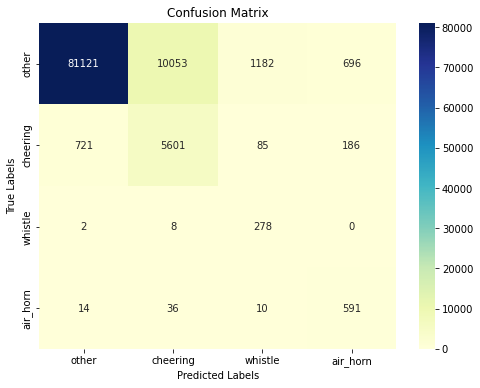

In [ ]:
#Print confusion matrix to see values distribution on each class

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) #convert probability for each class into class prediction
confusion_mat = confusion_matrix(y_test, y_pred)

class_labels = ['other', 'cheering', 'whistle', 'air_horn']
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ANN performance for concatenated_features without PCA

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_std, concatenated_features_labels, test_size=0.2)

X_train_0_all = X_train[y_train == 0]
X_train_1_all = X_train[y_train == 1]
X_train_2_all = X_train[y_train == 2]
X_train_3_all = X_train[y_train == 3]

X_train_0_downsampled_all = resample(X_train_0_all, replace=False, n_samples=X_train_2_all.shape[0], random_state=123)
X_train_1_downsampled_all = resample(X_train_1_all, replace=False, n_samples=X_train_2_all.shape[0], random_state=123)
X_train_3_downsampled_all = resample(X_train_3_all, replace=False, n_samples=X_train_2_all.shape[0], random_state=123)


X_train_downsampled_all = np.vstack((X_train_0_downsampled_all, X_train_1_downsampled_all, X_train_2_all, X_train_3_downsampled_all))
y_train_downsampled_all = np.hstack((np.zeros(X_train_0_downsampled_all.shape[0]), np.ones(X_train_1_downsampled_all.shape[0]), np.full(X_train_2_all.shape[0], 2), np.full(X_train_3_downsampled_all.shape[0], 3)))


In [25]:
model = ANN_model(concatenated_features.shape[1])
model.fit(X_train_downsampled_all, y_train_downsampled_all, epochs=50, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               15700     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

3144/3144 [==============================] - 7s 2ms/step - loss: 0.4638 - accuracy: 0.8827
Test loss: 0.4638045132160187
Test accuracy: 0.8827447891235352


# Fine-tuning via GridSearch

In [23]:
model = KerasClassifier(build_fn=ANN_model)

param_grid = {
    'optimizer' : ['rmsprop', 'SGD', 'adam'],
    'activation' : ['relu', 'sigmoid'],
    # 'batch_size': [32, 64, 128],
    # 'epochs': [50, 75, 100]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='accuracy')
grid_result = grid.fit(X_train_downsampled, y_train_downsampled)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\MANOS\AppData\Local\Temp/ipykernel_17184/2286083362.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=ANN_model, verbose=1)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               5700      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                            

# Results(accuracy, loss)

## PCA

  Training - accuracy: 0.92, loss: 0.22
  Testing - accuracy: 0.85, loss: 0.4

## NO PCA
  Training - accuracy:0.95, loss:0.13
  Testing - accuracy: 0.88, loss:0.46